In [575]:
import pandas as pd
import numpy as np
from astropy.table import Table


import seaborn as sns
sns.set_style('whitegrid')

from scipy.optimize import curve_fit
from gal_data import gal_data
from astropy import units as u
from astropy.modeling import models, fitting
from astropy.stats import sigma_clip
from astropy.modeling.models import Sersic1D
import findHalfLight

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
%matplotlib inline


In [576]:
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams['figure.facecolor'] = 'white'


In [3]:
from scipy.optimize import curve_fit
from scipy.stats import chisquare
from astropy.modeling import models, fitting

In [4]:
dfw1 = pd.read_pickle('radprofilepkls/W1_radprofiles.pkl')
dffuv = pd.read_pickle('radprofilepkls/FUV_radprofiles.pkl')
mmres = pd.read_csv('data/mmres_allotherstuff.csv')

In [819]:
dfnuv = pd.read_pickle('radprofilepkls/NUV_radprofiles.pkl')

In [5]:
mmres = mmres.drop(columns=[ 're_des',
 're',
 'ratio',
 'ratio2',
 'nummasked',
 'R25_arcsec'])

In [6]:
from gal_data import gal_data
temp = gal_data(['PGC'+str(i) for i in mmres.PGC])['PGC','INCL_DEG','MORPH','T'].to_pandas()
mmres = mmres.merge(temp,on='PGC')

In [7]:
mmres.head()

,col1,col2,PGC,OBJNAME,R25_DEG,LOGMASS,DIST_MPC,GALTYPE_COURSE,IDE,Com,Tmag,q,PosAng,n,Re,ratio_Salo,INCL_DEG,MORPH,T
0,ESO011-005,15.6,67162,ESO011-005,0.013026,9.412712,41.70,LT,ESO011-005,NaN,14.52,0.231,43.46,1.329,18.61,0.587911,83.910004,b'SBc ',5.9
1,ESO012-010,45.1,72957,ESO012-010,0.009350,9.230704,32.40,LT,ESO012-010,NaN,13.31,0.493,156.97,1.592,56.38,NaN,26.820000,b'SBd ',7.7
2,ESO012-014,47.8,181,ESO012-014,0.012555,8.699477,32.40,LT,ESO012-014,NaN,14.67,0.411,23.92,0.884,47.35,NaN,90.000000,b'SBm ',9.0
3,ESO013-016,26.3,5764,ESO013-016,0.017857,9.505092,24.55,LT,ESO013-016,NaN,12.75,0.508,168.64,1.314,38.85,0.332227,56.709999,b'SBcd',7.3
4,ESO015-001,28.6,13695,ESO015-001,0.011503,8.643700,22.70,LT,ESO015-001,NaN,14.39,0.357,110.22,1.131,34.34,NaN,90.000000,b'IB ',9.6


In [728]:
mmres[mmres.PGC==36932]

,col1,col2,PGC,OBJNAME,R25_DEG,LOGMASS,DIST_MPC,GALTYPE_COURSE,IDE,Com,...,mse,saloratio,mm15ratio,Re_mine2,mse2,saloratio2,mm15ratio2,n_mine2,nsratio,mse_fuv
2089,UGC06791,18.7,36932,UGC06791,0.017451,9.252669,22.5,LT,UGC06791,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [729]:
print(len(ns))
ns.insert(2089,np.nan)
print(len(ns))


2345
2346


In [820]:
hls = []
mses = []
ns = []
for i in mmres.index:
    pgc = fmmres.PGC[i]
    incl = mmres.INCL_DEG[i]
    r25 = mmres.R25_DEG[i]
    rp = dfnuv[dfnuv['gal']=='PGC'+str(pgc)]
    rp.r_arcsec/=3600. 
    mask = rp.r_arcsec<r25*2
    #rp.I/=rp.I.max()
    rp = rp[mask]
    #t = mmres['T'][i]
    #mass = mmres['LOGMASS'][i]
    nrange = np.arange(0.5,14,0.5)
        
    if len(rp.r_arcsec) ==0:
        print('empty r')
        hls.append(np.nan)
        mses.append(np.nan)
        ns.append(np.nan)
        continue
    try:
        ind = np.where(rp.r_arcsec<.5*r25)[0][-1]
        #if np.logical_and(mass>=10,t>1):
        #    sersic = models.Sersic1D(bounds = {'n':(1,7)})
        #else:
        sersic = models.Sersic1D(bounds = {'n':(0,14)})
        outlier_fit = fitting.FittingWithOutlierRemoval(fitting.LevMarLSQFitter(),sigma_clip, niter=3, sigma=2.5)
        fitted_model,filtered_data = outlier_fit(sersic,rp.r_arcsec,rp.I)#,weights=0.1*rp.I)
        filtered_data[:ind]=False
        
        fit = fitting.LevMarLSQFitter()
        fitted_model = fit(sersic,rp.r_arcsec[~filtered_data],rp.I[~filtered_data])#,weights=(0.1*rp.I[~filtered_data]))
        mse = np.nanmean((rp.I[~filtered_data] - fitted_model(rp.I[~filtered_data]))**2)
        print('')
        print(pgc)
        print(np.round(mse,decimals=2))
        """
        if mse>3.:
            ns_mse = []
            for n in nrange:
                sersic = models.Sersic1D(bounds = {'n':(n,n+1)})
                outlier_fit = fitting.FittingWithOutlierRemoval(fitting.LevMarLSQFitter(),sigma_clip, niter=3, sigma=3)
                fitted_model,filtered_data_chisq = outlier_fit(sersic,rp.r_arcsec[~filtered_data],rp.I[~filtered_data])#,weights=(0.1*rp.I[~filtered_data]))
                m = np.nanmean((rp.I[~filtered_data] - fitted_model(rp.I[~filtered_data]))**2)
                if m<mse:
                    mse=m
                    ns_mse.append(n)
                    print(mse,n)
                else:
                    pass
            if len(ns_mse)==0:
                print(ns_mse)
                print('none better')
                pass
            else:
                sersic = models.Sersic1D(bounds = {'n':(ns_mse[-1]-1,ns_mse[-1]+1)})
                fitted_model = fit(sersic,rp.r_arcsec[~filtered_data],rp.I[~filtered_data])
        """
        re = np.round(fitted_model.r_eff.value*3600,decimals=3)
        re*=0.9      
        re = np.round(re,decimals=3)

        saloratio = np.round(mmres.Re[i]/re,decimals=2)
        mm15ratio = np.round(mmres.col2[i]/re,decimals=2)

        n = np.round(fitted_model.n.value,decimals=3)
        print(re,saloratio,mm15ratio)
        print(n,mmres.n[i],np.round(mmres['T'][i],decimals=2))

        hls.append(re)
        mses.append(mse)
        ns.append(n)
        
        
        plt.figure(figsize=(6,4))
        plt.plot(rp.r_arcsec*3600,rp.I,'b.')
        plt.plot(rp.r_arcsec[~filtered_data]*3600,rp.I[~filtered_data],'r.')
        #plt.plot(rp.r_arcsec[:ind]*3600,rp.I[:ind],'g.')
        plt.plot(rp.r_arcsec*3600,fitted_model(rp.r_arcsec),'y-',lw=3)

        plt.yscale('log')
        #plt.xscale('log')
        plt.ylim(ymin= np.nanmin(rp.I[~filtered_data]))
        plt.xlabel('Radius [arcsec]',fontsize=14)
        plt.ylabel('log(I) [MJy/sr]',fontsize=14)
        plt.title(str(pgc)+'- I='+str(np.round(incl,decimals=2))+', re='+str(re)+', n='+str(n),fontsize=16)
        plt.savefig('plots/NUV_sersic/PGC'+str(pgc)+'.jpg',bbox_inches='tight')
        plt.close('all')
        
    except:
        print(pgc)
        hls.append(np.nan)
        mses.append(np.nan)
        ns.append(np.nan)
        
        plt.figure(figsize=(6,4))
        plt.plot(rp.r_arcsec*3600,rp.I,'b.')
       
        plt.yscale('log')
        #plt.xscale('log')
        plt.xlabel('Radius  [arcsec]',fontsize=14)
        plt.ylabel('log(I) [MJy/sr]',fontsize=14)
        plt.title(str(pgc)+'- I='+str(np.round(incl,decimals=2)),fontsize=16)
        plt.savefig('plots/NUV_sersic/PGC'+str(pgc)+'_nofit.jpg',bbox_inches='tight')
        plt.close('all')

empty r
empty r
empty r

5764
0.01
29.32 1.33 0.9
0.601 1.314 7.3
empty r

64648
0.0
27.792 2.26 0.92
0.463 3.126 5.9

67546
0.01
38.997 2.46 0.76
1.085 5.423 5.0

68712
0.0
39.774 0.87 0.83
0.324 0.712 5.1

68138
0.0
29.073 1.33 0.68
0.574 1.986 6.9
empty r
empty r

2445
0.0
31.695 0.95 0.82
0.654 0.835 7.0

2919
0.01
19.3 1.26 1.04
0.579 1.118 5.3
empty r

16567
0.01
21.211 0.57 0.51
0.595 1.377 -0.2

16780
0.0
43.454 0.86 0.83
0.814 1.409 9.0
empty r
empty r
empty r

11984
0.02
50.798 nan nan
0.93 nan 6.7

16172
0.0
65.284 0.67 0.67
0.61 0.848 9.7

17567
0.0
28.865 1.08 0.91
0.5 1.118 7.1

18051
0.0
33.538 0.99 0.87
0.387 0.526 10.0
empty r
empty r
empty r
empty r

1440
0.0
51.682 1.25 0.9
0.57 1.722 7.7
empty r

15749
0.0
36.228 0.48 0.39
0.698 1.079 4.8

17652
0.0
30.81 0.92 0.78
0.721 0.857 10.0
empty r

66142
0.0
46.563 3.34 0.89
0.916 2.565 9.0
empty r

15650
0.0
35.644 0.89 0.59
0.536 1.607 8.9

64909
0.0
62.239 0.95 0.45
1.386 2.252 8.9

65017
0.05
19.119 1.22 0.97
0.674 1.39


8673
0.0
44.073 0.7 0.52
0.522 0.815 5.8

8998
0.11
13.472 1.04 0.82
0.543 1.342 10.0
empty r
empty r

30041
0.01
37.294 0.69 0.64
1.052 1.708 7.8
empty r

36174
0.0
20.682 0.97 0.89
0.746 0.961 9.8
empty r

37692
0.0
30.279 1.16 1.03
0.345 0.681 5.9

37719
0.0
30.221 0.51 0.39
1.238 1.593 2.1
empty r

38173
0.0
32.864 1.06 0.83
0.742 1.61 6.0

38711
0.0
112.104 0.45 0.4
0.741 1.678 5.0

38916
0.0
35.924 1.15 0.74
0.391 1.949 4.0

39613
0.0
43.726 0.73 0.52
0.994 1.441 7.9
empty r

41504
0.01
16.942 1.29 1.19
0.572 1.169 6.1

41763
0.01
15.413 1.98 1.43
0.596 1.248 5.3

45552
0.0
20.682 0.76 0.63
0.609 1.015 4.9

46270
0.01
15.466 0.54 0.5
0.879 2.297 0.4
empty r

51685
0.0
45.823 0.8 0.66
0.633 1.405 8.0
empty r
empty r
empty r

52811
0.0
41.728 0.69 0.59
0.391 0.874 3.1

53176
0.0
21.222 0.69 0.64
0.465 1.311 3.2

53178
0.0
32.6 0.94 0.53
0.272 3.724 3.0

55388
0.01
24.665 0.67 0.56
0.537 1.327 7.2

56537
0.01
31.694 0.8 0.78
0.506 1.612 5.1

56723
0.0
38.581 0.97 0.84
0.361 0.953 5


10132
0.0
48.406 0.54 0.36
2.559 1.635 -0.6

10172
0.0
28.201 1.09 0.93
0.551 1.199 8.7

10175
0.01
81.217 0.32 0.22
2.725 5.01 -4.7

10208
0.0
73.791 0.85 0.59
0.565 1.969 3.1
empty r

10329
0.0
624.752 0.27 0.11
3.404 3.08 5.3

10313
0.02
15.174 0.94 0.76
0.662 1.761 0.2

10330
0.01
33.204 1.31 0.83
1.78 4.415 0.6
empty r

10496
0.04
36.913 1.13 1.05
0.548 1.785 5.2

10507
0.0
60.128 0.75 0.63
0.631 1.958 3.8

10488
5.23
136.035 0.57 0.43
3.77 4.589 3.3
empty r

10966
0.98
17.979 0.64 0.6
0.822 2.922 9.2

10965
0.0
72.59 0.49 0.39
0.538 0.855 5.2
empty r

11480
0.0
94.376 1.18 0.61
1.275 2.559 5.9

11479
0.0
64.9 nan 0.71
0.409 nan 5.0

11774
0.09
17.252 0.38 0.42
0.896 4.133 -2.6

11819
0.0
103.442 0.97 0.77
0.29 1.883 5.0

11836
0.01
64.31 0.97 0.65
0.706 1.758 6.0

12041
0.0
80.822 0.89 0.58
0.488 2.116 5.9

12007
0.0
60.752 1.1 0.8
0.159 1.551 4.0

12034
0.0
19.579 1.1 0.99
0.429 0.972 5.7

12209
0.02
50.097 2.17 1.21
1.655 6.084 0.1

12285
0.01
39.608 0.89 0.81
0.579 1.25 5.0




31428
0.01
40.368 0.99 0.88
0.259 0.845 5.1

31442
0.0
33.631 1.18 1.06
0.238 0.684 8.0
empty r

31528
0.0
29.0 0.28 0.21
0.285 1.515 7.5
empty r

31671
0.01
827.516 0.54 0.1
4.538 4.119 6.0

31708
0.01
30.784 0.74 0.62
0.431 1.615 5.7

31653
0.0
47.107 0.78 0.63
0.367 1.82 5.1

32059
0.01
20.111 0.82 0.64
0.649 3.263 2.9

31883
0.0
133.876 0.39 0.36
1.061 1.666 5.0
empty r

31982
0.0
40.299 1.05 1.01
0.309 0.691 5.9

32007
0.59
9.886 11.35 6.52
0.538 5.471 3.1

32103
0.47
15.529 0.73 0.55
1.118 2.323 4.1

32183
0.01
69.143 1.49 0.89
0.734 2.612 5.2

32044
0.0
32.919 0.78 0.7
0.447 0.868 5.0

32314
0.0
20.584 1.01 0.83
0.399 1.398 5.0
empty r

32192
0.0
61.925 1.13 0.82
0.288 4.79 2.1

32207
0.01
33.997 0.64 0.61
0.608 1.849 5.1
empty r

32287
0.03
32.335 0.71 0.41
1.958 3.01 1.0

32302
0.05
18.636 1.58 1.18
0.891 1.757 3.6
empty r

32306
0.02
38.081 1.01 0.9
0.455 1.425 5.3

32424
0.21
22.206 1.0 0.82
0.652 1.596 5.8
empty r

32719
0.0
52.407 0.52 0.47
0.86 1.278 4.0
empty r

32533
0

empty r

38943
0.0
93.796 1.05 0.72
0.165 1.547 6.9

38964
0.0
19.83 0.63 0.49
0.438 1.568 2.0
empty r

39025
0.0
35.869 0.97 0.91
0.12 0.745 5.9
empty r
empty r

39040
0.0
35.995 0.74 0.61
0.67 1.497 4.1
empty r

39114
0.01
44.827 0.67 0.55
0.54 1.482 6.7
empty r
empty r
empty r
empty r

39206
0.0
26.23 0.6 0.46
0.793 1.648 7.7

39184
0.0
25.966 0.87 0.79
0.205 0.899 3.1

39224
0.01
36.043 1.06 0.87
0.3 0.907 4.9

39225
11.22
94.226 0.84 0.66
3.309 1.391 9.8
empty r

39241
0.0
103.334 0.59 0.4
0.629 1.411 3.0
empty r
empty r

39328
0.0
52.384 0.74 0.49
0.977 4.077 1.0
empty r
empty r

39346
0.0
307.471 1.15 nan
0.321 1.32 8.0

39393
0.01
23.398 1.05 1.04
0.589 1.001 4.0

39366
0.01
25.571 0.86 0.77
0.488 1.134 6.5

39423
0.0
73.653 1.37 0.98
0.65 1.179 7.9

39422
0.01
167.591 0.81 0.84
1.176 0.676 6.0

39437
0.01
16.185 2.45 1.45
0.957 4.535 0.1

39461
0.0
35.15 1.36 0.9
0.666 1.181 9.0

39414
47.93
457.986 0.03 0.03
6.593 3.595 -0.8

39537
0.0
25.187 0.72 0.61
0.524 1.109 3.6

39578



44116
0.03
17.747 0.87 0.81
0.521 1.061 4.9

44086
0.02
37.926 0.71 0.57
0.411 1.04 5.9
empty r

44025
0.01
23.576 0.84 0.7
0.639 1.721 3.1

44191
0.02
193.648 2.62 0.15
3.541 15.412 2.0

44182
0.04
53.19 1.44 1.29
0.59 2.919 2.2
empty r
empty r
empty r

44719
0.0
33.701 1.29 0.97
1.323 2.098 -1.2

44829
0.01
39.818 1.03 0.38
1.081 5.639 4.0

44841
0.0
34.487 0.81 0.76
0.251 1.146 5.0
empty r

44847
0.0
36.895 1.52 0.84
0.187 3.567 3.0

44846
0.02
27.576 1.21 0.97
0.911 2.25 5.8

44958
0.32
43.466 0.33 0.27
2.891 1.445 10.0

45052
0.01
20.304 0.72 0.69
0.184 1.013 4.0
empty r

45177
0.0
25.545 0.87 0.78
0.497 1.124 6.9
empty r

45242
0.0
22.934 1.23 1.02
0.489 1.142 7.7

45246
0.0
52.098 0.67 0.45
0.686 3.647 6.0
empty r

45311
0.01
18.008 0.74 0.67
0.646 1.408 5.6

45437
0.01
33.573 1.38 1.09
0.607 1.495 6.7

45596
0.02
26.207 0.84 0.9
0.559 1.348 1.1

45574
0.0
28.416 3.84 1.05
0.125 6.386 4.0

45585
0.1
11.021 2.31 1.64
0.718 6.622 -0.8

45643
0.01
28.952 1.04 1.04
0.352 1.487 3.1



58115
0.01
18.879 0.9 0.79
0.467 1.007 4.1
empty r

58470
0.05
27.832 0.67 0.64
0.659 1.687 5.1

58827
0.03
34.65 0.81 0.66
0.498 0.986 5.0

58477
0.22
18.651 nan 1.42
1.238 nan 4.0

58891
0.0
37.166 1.04 0.85
0.615 1.454 5.9

58864
0.0
37.211 1.07 0.83
0.967 1.46 6.4

59083
0.05
23.786 0.88 0.79
0.63 1.724 3.4

59244
0.0
49.375 1.92 0.98
0.608 2.517 6.0

59340
0.0
23.554 0.9 1.1
0.163 0.945 4.8

59426
0.0
31.092 0.79 0.32
1.114 7.238 -1.8

60003
0.01
27.45 2.46 1.4
1.422 3.444 6.3
empty r

60291
0.01
36.722 1.07 0.86
0.576 1.597 5.8

60393
0.0
34.08 1.23 0.9
0.383 1.582 5.2
empty r

60921
0.02
49.547 1.04 0.94
0.171 0.741 5.8
empty r

64197
0.0
28.939 0.85 0.57
0.45 2.545 2.2

64427
0.0
69.054 0.63 0.57
0.355 1.095 3.7

64464
0.0
24.167 0.88 0.73
0.572 1.569 3.7

64632
0.0
65.34 0.99 0.37
1.388 4.761 2.3
empty r

64884
0.0
38.839 2.93 0.55
0.444 9.317 3.1

64980
0.0
86.631 0.43 0.39
0.416 3.459 4.0
empty r

66784
0.01
59.087 0.66 0.63
1.074 2.626 5.6
empty r

66869
0.0
30.993 1.14 0.


4063
0.0
44.737 1.1 0.63
0.772 1.416 6.5
empty r

4862
0.0
22.781 1.25 1.19
0.322 1.211 9.8

4913
0.0
40.82 0.89 0.89
0.55 0.71 9.0
empty r
empty r
empty r

5198
0.02
57.649 0.22 0.17
3.725 1.191 2.5

5345
0.0
20.529 0.88 0.87
0.276 0.689 9.3

5382
0.0
22.861 0.7 0.49
1.906 2.598 2.1

5761
0.04
14.302 1.1 1.14
0.593 1.076 9.5

5792
0.0
42.702 0.72 0.55
0.515 1.256 5.9

5794
0.0
19.901 0.96 0.78
0.496 0.843 5.8
empty r
empty r
empty r
empty r

6309
0.01
22.676 1.0 0.88
0.596 0.874 9.8
empty r

7663
0.0
27.825 0.52 0.4
0.47 0.908 5.9
empty r

7841
0.0
40.883 0.85 0.84
0.339 0.897 6.1
empty r
empty r
empty r
empty r

9126
0.0
23.163 1.02 1.04
0.325 0.629 6.4
empty r
empty r
empty r

9638
0.0
42.869 0.63 0.63
0.763 1.239 5.8
empty r

9888
0.0
102.229 0.56 0.45
0.62 1.403 5.8
empty r
empty r
empty r
empty r

11245
0.0
20.577 0.98 0.89
0.38 0.664 5.7
empty r

21854
0.0
25.425 0.92 0.73
0.417 1.158 5.8
empty r
empty r

22660
0.01
18.515 0.94 0.84
0.493 1.253 7.9

22561
0.01
26.186 0.94 0.89



43124
0.13
54.971 0.35 0.38
2.821 0.951 9.9

43397
0.0
52.844 0.75 0.62
0.547 1.197 3.3

43470
0.0
32.627 0.91 0.73
0.376 1.098 6.5
empty r

44014
0.0
45.195 1.16 0.98
0.53 1.107 6.9

44008
0.01
45.676 0.49 0.38
2.873 3.043 5.5
empty r

43975
0.0
26.856 0.73 0.61
0.642 1.767 4.7

44089
0.01
32.423 0.78 0.75
1.654 0.977 8.1

44125
0.0
26.511 0.95 0.78
0.518 1.634 6.5

44254
0.0
34.898 0.52 0.46
0.652 1.277 3.6

44450
0.0
26.727 1.74 0.92
0.884 2.545 7.7

44432
0.0
53.66 0.63 0.58
0.578 1.601 5.8
empty r

44961
0.0
45.407 0.81 0.67
0.556 1.205 6.4
empty r

45079
0.0
109.382 1.1 0.16
1.332 14.458 2.4
empty r
empty r

45372
0.0
52.718 1.54 1.44
0.235 0.637 9.9

45684
0.0
47.534 0.83 0.81
0.65 1.257 6.0

45807
0.0
23.96 0.81 0.74
0.656 1.457 6.0
empty r

45992
0.0
30.31 0.95 0.91
0.65 0.948 5.2
empty r
empty r

46386
0.0
34.881 1.56 0.83
0.651 1.963 6.6

46563
0.0
43.272 0.95 0.85
0.68 1.137 8.9

46952
0.0
40.77 1.56 1.06
0.578 1.603 9.8
empty r

47371
0.0
24.618 1.21 0.87
0.676 1.647 7.9


In [724]:
(mmres.Re_mine2/hls).describe()

count    1385.000000
mean        3.718406
std        37.312883
min         0.001794
25%         0.724409
50%         0.927794
75%         1.247722
max      1042.562526
Name: Re_mine2, dtype: float64

In [649]:
(mmres.col2/hls).describe()

count    1542.000000
mean        0.988562
std         8.789468
min         0.000773
25%         0.540911
50%         0.779757
75%         0.941934
max       344.094488
Name: col2, dtype: float64

In [48]:
import pandasFunctions

In [821]:
#mmres['Re_mine2'] = hls
mmres['Re_mine_nuv']=hls

In [822]:
mmres['mse_nuv']=mses
mmres['n_mine_nuv']=ns

In [81]:
#mmres['Re_mine']*=.9

In [823]:
mmres['saloratio2'] = mmres.Re/mmres.Re_mine2
mmres['mm15ratio2'] = mmres.col2/mmres.Re_mine2
#mmres['nsratio'] = mmres.n/mmres.n_mine2
mmres['nsratio'] = mmres.n_mine2/mmres.n_mine_nuv
mmres['bandratio'] = mmres.Re_mine2/mmres.Re_mine_nuv

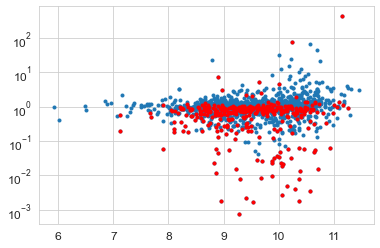

In [773]:
mask = np.logical_or(mmres.Re_mine2>350,mmres.Re_mine2<5)
mask = np.logical_or(mask,mmres.INCL_DEG>75.)
plt.plot(mmres.LOGMASS,mmres.saloratio2,'.')
plt.plot(mmres.LOGMASS[mask],mmres.saloratio2[mask],'r.')
#plt.plot(mmres.iloc[~maskedArray].LOGMASS,mmres.iloc[~maskedArray].saloratio,'r.')
#plt.plot(mmres.LOGMASS[mask],mmres.saloratio[mask],'y.')

plt.yscale('log')

In [824]:
med = pandasFunctions.rollingmedainXY(mmres[['LOGMASS','mse','bandratio','nsratio']][~mask],'LOGMASS',
                                      np.arange(8,11,.1))



In [825]:
mad = pandasFunctions.rollingMADXY(mmres[['LOGMASS','mse','bandratio','nsratio']][~mask],'LOGMASS',
                                   np.arange(8,11,.1))

In [815]:
(0.434*mad.bandratio/med.bandratio).median()

0.09249742073479804

In [816]:
#(0.434*mad.mm15ratio2/med.mm15ratio2).median()

In [713]:
#med = med[~mask]
#mad = mad[~mask]

(-0.5298785262673986, 0.2)

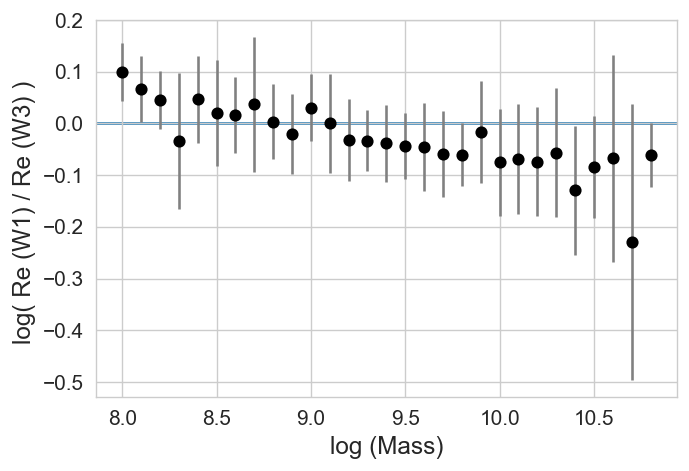

In [826]:
plt.figure(dpi=125)
plt.plot(np.arange(8,11,.1)[:-1],np.log10(med.bandratio),'ko')
plt.errorbar(np.arange(8,11,.1)[:-1],np.log10(med.bandratio),yerr=0.434*(mad.bandratio/med.bandratio),fmt='none',color='gray')
plt.axhline(y=0,zorder=0)
plt.ylabel('log( Re (W1) / Re (W3) ) ')
plt.xlabel('log (Mass)')
plt.ylim(ymax=0.2)
#plt.yscale('log')
#plt.savefig('plots/bandratio_w1w2_finegrid.png',bbox_inches='tight')

Text(0.5, 0, 'log (Mass)')

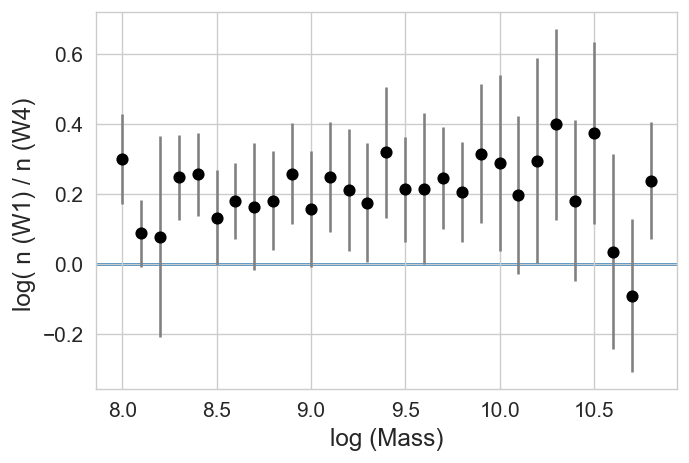

In [827]:
plt.figure(dpi=125)
plt.plot(np.arange(8,11,.1)[:-1],np.log10(med.nsratio),'ko')
plt.errorbar(np.arange(8,11,.1)[:-1],np.log10(med.nsratio),yerr=0.434*(mad.nsratio/med.nsratio),fmt='none',color='gray')
plt.axhline(y=0,zorder=0)
plt.ylabel('log( n (W1) / n (W4) ')
plt.xlabel('log (Mass)')
#plt.ylim(-0.25,0.6)
#plt.yscale('log')
#plt.savefig('plots/w1w2ratio_n_log_mad_finegrid.png',bbox_inches='tight')

In [ ]:
plt.figure(dpi=125)
plt.plot(np.arange(8,11,.1)[:-1],np.log10(med.nsratio),'ko')
plt.errorbar(np.arange(8,11,.1)[:-1],np.log10(med.nsratio),yerr=0.434*(mad.nsratio/med.nsratio),fmt='none',color='gray')
plt.axhline(y=0,zorder=0)
plt.ylabel('log( n (W1) / n (W2) ')
plt.xlabel('log (Mass)')
#plt.ylim(-0.25,0.6)
#plt.yscale('log')
plt.savefig('plots/w1w2ratio_n_log_mad_finegrid.png',bbox_inches='tight')

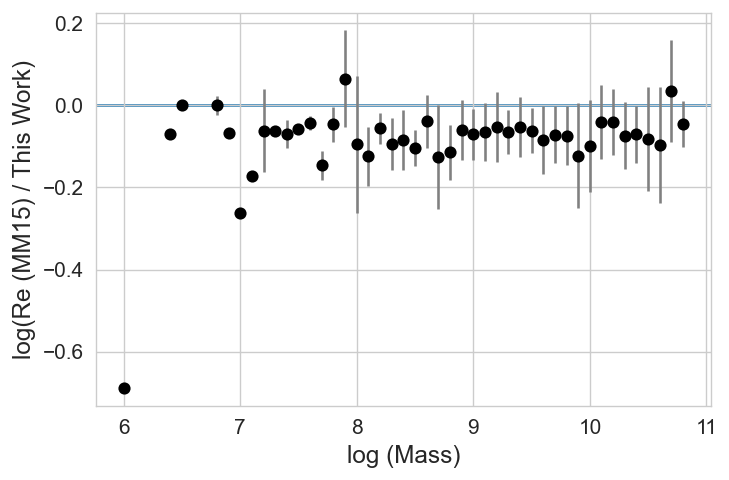

In [721]:
plt.figure(dpi=125)

plt.plot(np.arange(6,11,.1)[:-1],np.log10(med.mm15ratio2),'ko')
plt.errorbar(np.arange(6,11,.1)[:-1],np.log10(med.mm15ratio2),yerr=0.434*(mad.mm15ratio2/med.mm15ratio2),fmt='none',color='gray')
plt.axhline(y=0,zorder=0)
plt.ylabel('log(Re (MM15) / This Work)')
plt.xlabel('log (Mass)')
plt.tight_layout()
#plt.show()
#plt.savefig('plots/mm15ratio_log_n_mad_finegrid.png',bbox_inches='tight')
#plt.yscale('log')

In [264]:
filtered_data = sigma_clip(mmres.saloratio, sigma=2.2, maxiters=None,cenfunc=np.nanmedian, masked=True, copy=False)

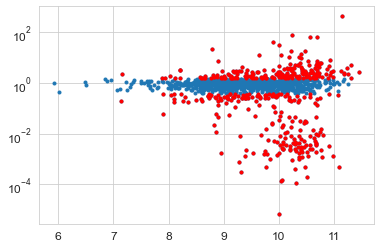

In [265]:
mask = mmres.mse>5
plt.plot(mmres.LOGMASS,mmres.saloratio,'.')
plt.plot(mmres.LOGMASS[filtered_data.mask],mmres.saloratio[filtered_data.mask],'r.')
#plt.plot(mmres.LOGMASS[mask],mmres.saloratio[mask],'y.')

plt.yscale('log')

In [267]:
from astropy.stats import sigma_clipped_stats
sigma_clipped_stats(mmres.saloratio, sigma=2, maxiters=5) 

(0.9037632654377373, 0.9158414752451673, 0.2947368492267774)

In [811]:
mmres.to_csv('mmres_placeholder_w1_w2__w3_w4_fuv.csv',index=False)


In [ ]:
test=mmres[['LOGMASS','saloratio','mm15ratio','mse']].copy()
test["mad"] = test.groupby(by=)["Cost"].transform("mad")
df = df.loc[df.mad<3]

In [ ]:

You can get your aggregate function on the grouped object:

df["mad"] = df.groupby(['Name','Type'])["Cost"].transform("mad")
df = df.loc[df.mad<3]